In [14]:
from pygam import LinearGAM, s, f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume daily_agg is already created as in your previous steps
df = pd.read_parquet(
    r"https://github.com/ISL-0111/IDS701_Team_Project/raw/refs/heads/main/Data/cleaned_data.parquet"
)
df["accept_hour"] = df["accept_time"].dt.hour

# --- Step 1: Filter Data for Top Regions ---
top_regions = df["region_id"].value_counts().head(14).index
df_filtered = df[df["region_id"].isin(top_regions)]

# --- Step 2: Create Daily Aggregations per Courier ---
daily_agg = (
    df_filtered.groupby(["courier_id", "accept_date"])
    .agg(
        region_id=("region_id", "first"),  # Ensure region_id is preserved
        task_count=("order_id", "nunique"),
        avg_delivery_duration_min=("delivery_duration_minutes", "mean"),
        avg_distance_km=("distance_km", "mean"),
        delivery_hour_mode=("accept_hour", lambda x: x.mode()[0]),
    )
    .reset_index()
)
threshold = daily_agg["task_count"].median()
daily_agg["high_load"] = (daily_agg["task_count"] > threshold).astype(int)
daily_agg["task_count_c"] = daily_agg["task_count"] - threshold

# Time binning
daily_agg["hour_bin"] = pd.cut(
    daily_agg["delivery_hour_mode"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False,
)
daily_agg["log_duration"] = np.log(
    daily_agg["avg_delivery_duration_min"].replace(0, 0.001)
)

# Define features and target
X = daily_agg[["task_count", "avg_distance_km", "hour_bin"]]
y = daily_agg["avg_delivery_duration_min"]

# Encode 'hour_bin' (categorical variable) numerically
X = X.copy()
X["hour_bin"] = X["hour_bin"].astype("category").cat.codes

In [15]:
# --- Build and fit the GAM model ---

# s(0): spline for task_count
# s(1): spline for avg_distance_km
# f(2): factor/categorical term for hour_bin
gam = LinearGAM(s(0) + s(1) + f(2)).fit(X.values, y)

# --- Print model summary ---
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.1299
Link Function:                     IdentityLink Log Likelihood:                               -260545.8812
Number of Samples:                        27498 AIC:                                           521150.0221
                                                AICc:                                           521150.086
                                                GCV:                                             5207.6972
                                                Scale:                                           5198.1088
                                                Pseudo R-Squared:                                   0.2675
Feature Function                  Lam

C:\Users\Afag\AppData\Local\Temp\ipykernel_25436\713105044.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


s(0)   - task_count.
s(1)   - avg_distance_km.
f(2)   - hour_bin 

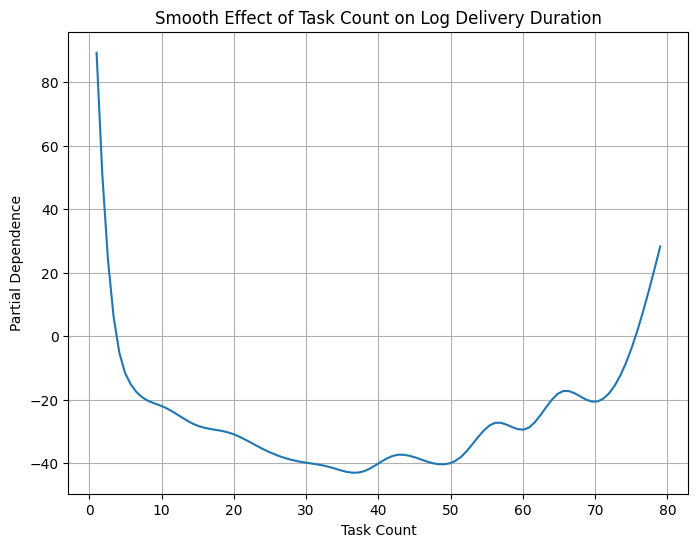

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- Create manual grid for task_count with valid fixed values for other features
task_count_grid = np.linspace(X["task_count"].min(), X["task_count"].max(), 100)

# Create fixed values for avg_distance_km and hour_bin
avg_distance_fixed = X["avg_distance_km"].mean()  # hold distance at mean
hour_bin_fixed = (
    1  # set to a valid value (you can use 1 or 3 based on your error message)
)

# Build full grid
XX = np.column_stack(
    [
        task_count_grid,
        np.full_like(task_count_grid, avg_distance_fixed),
        np.full_like(task_count_grid, hour_bin_fixed),
    ]
)

# --- Now plot safely
plt.figure(figsize=(8, 6))
plt.plot(task_count_grid, gam.partial_dependence(term=0, X=XX))
plt.title("Smooth Effect of Task Count on Log Delivery Duration")
plt.xlabel("Task Count")
plt.ylabel("Partial Dependence")
plt.grid()
plt.show()

One of the most attractive properties of GAMs is that we can decompose and inspect the contribution of each feature to the overall prediction.


This is done via partial dependence functions.

The smooth effect of task count on delivery duration exhibits a U-shaped relationship. At low task counts, delivery durations per task are relatively high, possibly due to under-utilization. As task counts increase into the moderate range (10–40 tasks per day), delivery times stabilize and efficiency improves. However, beyond approximately 50–60 tasks per day, delivery durations begin to rise again, suggesting diminishing returns to courier workload optimization and the onset of operational strain.